[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Steaming

## Review

module-2では、グラフの状態とメモリをカスタマイズする方法をいくつか説明しました。
 
そして、長期(long-running)の会話できる外部メモリを持つチャットボットを構築しました。

## Goals

このモジュールでは `human-in-the-loop` について説明します。

`human-in-the-loop` の舞台を整えるために、まずストリーミング(streaming)を学びます。ストリーミングは実行の過程でグラフの出力（例えばノードの状態やチャットモデルのトークン）を可視化するいくつかの方法を提供します。




In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 


LangGraphは、[第一級のストリーミングサポート](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming)を備えています。

module-2のChatbotをセットアップし、実行中にグラフからの出力をストリーミングする様々な方法を示しましょう。


In [1]:
import os
import getpass


def _set_env(var: str) -> None:
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

`RunnableConfig` と `call_model` を使って、トークン単位(token-wise)のストリーミングを可能にしていることに注意してください。
これは[python < 3.11でのみ必要です](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/)。このノートブックをCoLabで実行する場合、python 3.xを使用するためです。


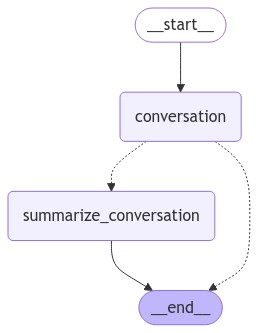

In [2]:
from typing import Literal
from IPython.display import Image, display

from langchain_core.messages.base import BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from traitlets import Any

# LLM
model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)


# State
class State(MessagesState):
    summary: str


# モデルを呼び出すロジックを定義
def call_model(state: State, config: RunnableConfig) -> dict[str, BaseMessage]:
    # 要約があれば取得する
    summary = state.get("summary", "")

    # 要約があれば、それに追加する
    if summary:
        # 要約するためのプロンプトを作成する
        system_message = f"これまでの会話の要約: {summary}"

        # 新しい message に要約を追加する
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}


def summarize_conversation(state: State) -> dict[str, Any]:
    # 最初に, 既存の要約を取得
    summary = state.get("summary", "")

    # 要約するためのプロンプトを作成する
    if summary:
        # 要約がすでにある場合
        summary_message = (
            f"これは今までの会話の要約です: {summary}\n\n" + "上の新しいメッセージを考慮して、要約を拡張します:"
        )

    else:
        summary_message = "上記の会話を要約してください:"

    # 履歴にプロンプトを追加する
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 直近2つのメッセージ以外は削除する
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}


# 会話を終了するか要約するかを決定
def should_continue(state: State) -> Literal["summarize_conversation"] | Literal["__end__"]:
    """次に実行するnodeを返却します"""

    messages = state["messages"]

    # メッセージが6つより多い場合は、会話を要約します
    if len(messages) > 6:
        return "summarize_conversation"

    # そうでなければ終了
    return END


# 新しいグラフを定義する
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Streaming full state

それでは、[グラフの状態をストリームする](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming) 方法について説明します。

`.stream`と`.astream`は結果をストリームバックするための同期と非同期のメソッドです。

LangGraphは[グラフの状態](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)に対して、いくつかの[異なるストリーミングモード](https://langchain-ai.github.io/langgraph/how-tos/stream-values/)をサポートしています：

* `value`： 各ノードが呼び出された後、グラフの完全な状態をストリームします。
* `updates`： 各ノードが呼び出された後、グラフの状態を更新します。

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

`stream_mode="updates"` を見てみましょう。

`updates`でストリームを流すので、グラフのノードが実行された後の状態の更新だけを見ることができます。

各 `chunk` は dict で、`node_name` をkey、更新された状態をvalueとします。


In [3]:
# threadを作成
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="こんにちは!ランスです。")]},
    config,
    stream_mode="updates",
):
    print(chunk)

{'conversation': {'messages': AIMessage(content='こんにちは、ランスさん！今日はどのようにお手伝いできますか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 13, 'total_tokens': 31, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'stop', 'logprobs': None}, id='run-fe5157d6-f7ec-4210-b0c6-adc106a5f269-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens': 31})}}


では、状態の更新を表示してみましょう。


In [5]:
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="こんにちは!ランスです。")]},
    config,
    stream_mode="updates",
):
    chunk["conversation"]["messages"].pretty_print()

================================== Ai Message ==================================

こんにちは、ランスさん！今日はどのようにお手伝いできますか？


ここで、`stream_mode="values"` を見ることができます。

これは `conversation` ノードが呼ばれた後のグラフの `完全な状態(full state)` です。



In [6]:
# 再度会話を始めます
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="こんにちは!ランスです。")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("---" * 25)

================================ Human Message =================================

こんにちは!ランスです。
---------------------------------------------------------------------------
================================ Human Message =================================

こんにちは!ランスです。
================================== Ai Message ==================================

こんにちは、ランスさん！今日はどのようにお手伝いできますか？
---------------------------------------------------------------------------


 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.


### Streaming tokens

グラフの状態以外のものをストリーミングしたいことがよくあります。

特に、チャットモデルの呼び出しでは、トークンが生成されるときにストリームするのが一般的です。

これは[`.astream_events`メソッドを使って](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node)実現できます。このメソッドはノード内部で発生したイベントをストリームバックします！

各イベントはいくつかのキーを持つ dict です：

* `event`: 発行されているイベントの種類です。
* `name`: イベントの名前です
* `data`: イベントに関連付けられたデータです。
* `metadata`: `langgraph_node` を含みます。これは、イベントを発行するノードです。

それでは見てみましょう。


In [7]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="NFLの49ersというチームについて教えてください")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

ポイントは、グラフ内のチャットモデルからのトークンは `on_chat_model_stream` 型を持つということです。

`event['metadata']['langgraph_node']`を使ってストリーム元のノードを選択することができます。

また、`event['data']` を使って各イベントの実際のデータを取得することができ、この場合、`AIMessageChunk` 型です。


In [8]:
node_to_stream = "conversation"
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="NFLの49ersというチームについて教えてください")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='サ', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='ン', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='フ', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='ラン', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='シ', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='ス', additional_kwargs={}, response_metadata={}, id='run-847f270f-1828-4c60-952a-103d3e01cd2f')}
{'chunk': AIMessageChunk(content='コ', additional_kwargs={}, response_metadata={}, id='run-

上記のように、`AIMessageChunk` を取得するには `chunk` キーを使います。`event["data"]`は、dictで、key: `chunk`、value: `AIMessageChunk` なので。


In [9]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="NFLの49ersというチームについて教えてください")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|サ|ン|フ|ラン|シ|ス|コ|・|49|ers|（|フォ|ーティ|ーナ|イ|ナ|ーズ|）は|、|ア|メリ|カ|合|衆|国|の|プロ|ア|メリ|カ|ン|フ|ット|ボ|ール|チ|ーム|で|、|NFL|（|ナ|ショ|ナル|・|フ|ット|ボ|ール|・|リー|グ|）の|N|FC|（|ナ|ショ|ナル|・|フ|ット|ボ|ール|・|カ|ン|ファ|レン|ス|）|西|地区|に|所属|しています|。|チ|ーム|は|カ|リ|フォ|ル|ニ|ア|州|サ|ンタ|クラ|ラ|に|本|拠|地|を|置|き|、|ホーム|スタ|ジ|ア|ム|は|リ|ーバ|イス|・|スタ|ジ|ア|ム|です|。

|49|ers|は|194|6|年|に|設|立|され|、|NFL|に|加盟|した|の|は|194|9|年|です|。|チ|ーム|名|の|「|49|ers|」は|、|184|9|年|の|カ|リ|フォ|ル|ニ|ア|・|ゴ|ールド|ラ|ッシュ|に|ち|なん|で|います|。|チ|ーム|カラー|は|ス|カ|ーレ|ット|と|ゴ|ールド|で|、|これ|も|ゴ|ールド|ラ|ッシュ|に|関連|しています|。

|49|ers|は|、|198|0|年代|から|199|0|年代|に|か|け|て|非常|に|成功|した|時|期|を|迎|え|、|ス|ーパ|ーボ|ウ|ル|を|5|回|制|覇|しました|。|特|に|、|ジョ|ー|・|モ|ンタ|ナ|や|ス|ティ|ーブ|・|ヤ|ング|と|い|った|伝|説|的|な|ク|ォ|ータ|ーバ|ック|が|在|籍|して|いた|時|期|は|、|チ|ーム|の|黄金|時|代|と|されています|。また|、|ジェ|リー|・|ライ|ス|など|の|名|選|手|も|この|時|期|に|活|躍|しました|。

|チ|ーム|は|その|後|も|何|度|か|ス|ーパ|ーボ|ウ|ル|に|出|場|して|お|り|、|近|年|も|強|豪|チ|ーム|として|知ら|れ|ています|。|49|ers|は|、|堅|実|な|ディ|フェ|ンス|と|効果|的|な|オ|フェ|ンス|戦|略|で|知ら|れ|、|ファ|ン|から|の|支持|も|厚|い|チ|ーム|です|。||

### LangGraph APIによるストリーミング

--

**⚠️ 注意**

*現状、LangGraph Studioの実行にはMacが必要です。*

*このノートブックをCoLabで実行している場合は、このステップをスキップしてください*

--

LangGraph APIは[ストリーミングをファーストクラス並にサポートしています](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#streaming)。

`module-3/studio/langgraph.json`に設定された`module-3/studio/agent.py`を使用します。

LangGraph APIはStudioのバックエンドとして機能します。

私たちはLangGraph SDKを通して直接LangGraph APIとやりとりすることができます。

LangGraph Studioからローカル・デプロイのURLを取得するだけです。

![Screenshot 2024-08-27 at 2.20.34 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf8943c3d4df239cbf0f_streaming2.png)



In [10]:
# 訳注: Dockerを使っている場合は、Linuxなので、以下は実行不可です。
import platform
from IPython import get_ipython

if "google.colab" in str(get_ipython()) or platform.system() != "Darwin":
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

Exception: Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac

In [10]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:56091"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

以前のように、[`values`ストリーム](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/)としましょう。

In [11]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"
):
    print(event)

StreamPart(event='metadata', data={'run_id': '1ef6a3d0-41eb-66f4-a311-8ebdfa1b281f'})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '345c67cf-c958-4f89-b787-540fc025080c', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_iIPryzZZxRtXozwwhVtFObNO', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai'

ストリームされたオブジェクト:

* `event`： 型
* `data`： 状態

In [12]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"
):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=" * 25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} id='f51807de-6b99-4da4-a798-26cf59d16412'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': None} id='run-fa4ab1c6-274d-4be5-8c4a-a6411c7c35cc' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_imZHAw7kvMR2ZeKaQVSlj25C', 'type': 'tool_call'}]
content='6' additional_kwargs={'additional_kwargs': {}, 'response_metadata': {}, 'status': 'success'} name='multiply' id='3e7bbfb6-aa82-453a-969c-9c753fbd1d74' tool_call_id='call_imZHAw7kvMR2ZeKaQVSlj25C'
conte

API経由でのみサポートされる新しいストリーミングモードがいくつかあります。

例えば、[`messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/)を使うことで、上記のようなケースに対応することができます！

このモードは現在、グラフに `messages` キーがあることを前提としています。

`messages` モードを使用して発行されるイベントには2つの属性があります：

* `event`： これはイベントの名前です。
* `data`: これはイベントに関連するデータです。



In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    print(event.event)

metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/complete


いくつかのイベントを見ることができます： 

* `metadata`: 実行に関するメタデータ
* `messages/complete`: 完成したメッセージ
* `messages/partial`: チャットモデルのトークン

型については[こちら](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages)を参照してください。

それでは、これらのメッセージをストリーミングする方法を説明しましょう。

メッセージ内のツールコール(tool call)の形式を改善するために、ヘルパー関数を定義します。



In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")


def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}")
        return "\n".join(formatted_calls)
    return "No tool calls"


async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",
):
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 1ef6a3da-687f-6253-915a-701de5327165
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_IL4MGMtr1fEpR3Yd9c2goLd8, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal